# Etude faisabilité de moteur de classification 

## Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, à partir du texte (en anglais) et de l’image.

## Ressources 

* Source / Images 
* Source / flipkart_com-ecommerce_sample_1050.csv

# Critères d'évaluation OC

Prétraiter des données non structurées de type texte en prenant en compte les normes liées à la propriété intellectuelle et réaliser un feature engineering adapté aux modèles d'apprentissage afin d’obtenir un jeu de données exploitables.
* CE1 Le candidat a nettoyé les champs de texte (suppression de la ponctuation et des mots de liaison, mise en minuscules) 
* CE2 Le candidat a écrit une fonction permettant de “tokeniser” une phrase.
* CE3 Le candidat a écrit une fonction permettant de “stemmer” une phrase.
* CE4 Le candidat a écrit une fonction permettant de “lemmatiser” une phrase.
* CE5 Le candidat a construit des features ("feature engineering") de type bag-of-words (bag-of-words standard : comptage de mots, et Tf-idf), avec des étapes de nettoyage supplémentaires : seuil de fréquence des mots, normalisation des mots.
* CE6 Le candidat a testé une phrase ou un court texte d'exemple, pour illustrer la bonne réalisation des 5 étapes précédentes.
* CE7 Le candidat, en complément de la démarche de type “bag-of-words”, a mis en oeuvre 3 démarches de word/sentence embedding : Word2Vec (ou Doc2Vec ou Glove ou FastText), BERT, et USE (Universal Sentence Encoder).
* CE8 Le candidat s’assure que le texte traité ne relève pas d’une propriété intellectuelle dont l’utilisation ou la modification est interdite

# Imports

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
import wordcloud 
import string

from collections import Counter
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk.tokenize import word_tokenize, wordpunct_tokenize 
from nltk.corpus import words 
from nltk.corpus import stopwords 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.models import Word2Vec

from sklearn.manifold import TSNE

import cv2


# Downloads 

In [2]:
# Télécharger les ressources nécessaires pour nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /Users/tarek/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tarek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tarek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/tarek/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Read Data

In [3]:
data = pd.read_csv('../Source/flipkart_com-ecommerce_sample_1050.csv')

# EDA

In [4]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [5]:
data.tail()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZGFD3RCE,3465.0,1333.0,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,False,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1049,f2f027ad6a6df617c9f125173da71e44,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-large-vinyl-s...,Uberlyfe Large Vinyl Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE2ZEPACRQJKH7,1190.0,595.0,f2f027ad6a6df617c9f125173da71e44.jpg,False,Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...,4,4,Uberlyfe,"{""product_specification""=>[{""key""=>""Sales Pack..."


## Structure

In [6]:
data.shape

(1050, 15)

## Types

In [7]:
data.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

## NaN and duplicated

In [8]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

In [9]:
data.nunique()

uniq_id                    1050
crawl_timestamp             149
product_url                1050
product_name               1050
product_category_tree       642
pid                        1050
retail_price                354
discounted_price            424
image                      1050
is_FK_Advantage_product       2
description                1050
product_rating               27
overall_rating               27
brand                       490
product_specifications      984
dtype: int64

In [10]:
data.duplicated().sum()

0

## Analyse de product_category_tree

In [11]:
data['product_category_tree'].unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

Le séparateur >> indique les différents niveaux de branches des produits.

In [12]:
from collections import defaultdict

In [13]:
# Initialiser un dictionnaire par niveau de catégorie
category_levels = defaultdict(int)

# Parcourir les catégories et mettre à jour le dictionnaire
for category in data['product_category_tree']:
    # Diviser la chaîne en branches
    branches = [branch.strip() for branch in category.split(">>")]

    # Mettre à jour le dictionnaire avec le nombre de produits pour chaque niveau de catégorie
    for i, branch in enumerate(branches, start=1):
        category_levels[i] += 1

# Afficher les résultats
for level, count in category_levels.items():
    print(f"{count} produits sur {level} branches")

1050 produits sur 1 branches
1050 produits sur 2 branches
1047 produits sur 3 branches
679 produits sur 4 branches
405 produits sur 5 branches
127 produits sur 6 branches
57 produits sur 7 branches


In [14]:
# Initialiser un dictionnaire par catégorie
category_counts = defaultdict(int)

# Parcourir les catégories et mettre à jour le dictionnaire
for category in data['product_category_tree']:
    # Extraire le nom de la catégorie avant le premier ">>"
    main_category = category.split(">>")[0].lstrip(' ["').strip()

    # Mettre à jour le dictionnaire avec le nombre de produits pour chaque catégorie
    category_counts[main_category] += 1

# Afficher les résultats
for category, count in category_counts.items():
    print(f"{count} produits dans la catégorie {category}")

150 produits dans la catégorie Home Furnishing
150 produits dans la catégorie Baby Care
150 produits dans la catégorie Watches
150 produits dans la catégorie Home Decor & Festive Needs
150 produits dans la catégorie Kitchen & Dining
150 produits dans la catégorie Beauty and Personal Care
150 produits dans la catégorie Computers


In [15]:
# Extraire la liste des catégories à partir du dictionnaire
main_categories = list(category_counts.keys())
print(main_categories)

['Home Furnishing', 'Baby Care', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Beauty and Personal Care', 'Computers']


In [16]:
# Initialiser un dictionnaire par catégorie
category_counts = defaultdict(int)

# Fonction pour extraire la catégorie principale
def extract_main_category(category):
    # Extraire le nom de la catégorie avant le premier ">>"
    main_category = category.split(">>")[0].lstrip(' ["').strip()
    return main_category

# Appliquer la fonction à chaque élément de la colonne 'product_category_tree' pour extraire la catégorie principale
data['main_category'] = data['product_category_tree'].apply(extract_main_category)

# Parcourir les catégories et mettre à jour le dictionnaire de comptage
for category in data['main_category']:
    category_counts[category] += 1

# Afficher les résultats
for category, count in category_counts.items():
    print(f"{count} produits dans la catégorie {category}")

150 produits dans la catégorie Home Furnishing
150 produits dans la catégorie Baby Care
150 produits dans la catégorie Watches
150 produits dans la catégorie Home Decor & Festive Needs
150 produits dans la catégorie Kitchen & Dining
150 produits dans la catégorie Beauty and Personal Care
150 produits dans la catégorie Computers


In [17]:
data['main_category']

0       Home Furnishing
1             Baby Care
2             Baby Care
3       Home Furnishing
4       Home Furnishing
             ...       
1045          Baby Care
1046          Baby Care
1047          Baby Care
1048          Baby Care
1049          Baby Care
Name: main_category, Length: 1050, dtype: object

## Pré traitement de la colonne description

In [18]:
# Fonction pour prétraiter le texte
def preprocess_text(text):
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Mettre en minuscules
    text = text.lower()
    
    # Tokenisation
    words = nltk.word_tokenize(text)
    
    # Supprimer les mots de liaison
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Reformer le texte
    preprocessed_text = ' '.join(words)
    
    return preprocessed_text

# Appliquer la fonction preprocess_text à la colonne 'description'
data['description_preprocessed'] = data['description'].apply(preprocess_text)

In [19]:
data['description_preprocessed']

0       key features elegance polyester multicolor abs...
1       specifications sathiyas cotton bath towel 3 ba...
2       key features eurospa cotton terry face towel s...
3       key features santosh royal fashion cotton prin...
4       key features jaipur print cotton floral king s...
                              ...                        
1045    oren empower extra large self adhesive sticker...
1046    wallmantra large vinyl sticker sticker pack 1 ...
1047    buy uberlyfe extra large pigmented polyvinyl f...
1048    buy wallmantra medium vinyl sticker sticker rs...
1049    buy uberlyfe large vinyl sticker rs595 online ...
Name: description_preprocessed, Length: 1050, dtype: object

## Tokenization

In [20]:
# Fonction pour tokeniser une phrase
def tokenize_sentence(sentence):
    # Utiliser la fonction word_tokenize pour tokeniser la phrase en mots
    tokens = nltk.word_tokenize(sentence)
    return tokens

# Exemple d'utilisation de la fonction
sentence = "This is a sample sentence for tokenization."
tokens = tokenize_sentence(sentence)
print(tokens)

['This', 'is', 'a', 'sample', 'sentence', 'for', 'tokenization', '.']


## Stemmer

In [21]:
# Créer une instance de PorterStemmer
stemmer = PorterStemmer()

# Fonction pour stemmer une phrase
def stem_sentence(sentence):
    # Tokeniser la phrase en mots
    tokens = nltk.word_tokenize(sentence)
    # Stemmer chaque mot dans la liste de tokens
    stemmed_words = [stemmer.stem(word) for word in tokens]
    # Rejoindre les mots stemmés en une phrase
    stemmed_sentence = ' '.join(stemmed_words)
    return stemmed_sentence

# Exemple d'utilisation de la fonction
sentence = "I am riding in a car."
stemmed_sentence = stem_sentence(sentence)
print(stemmed_sentence)

i am ride in a car .


## Lemmatizer

In [22]:
# Créer une instance de WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Fonction pour lemmatiser une phrase
def lemmatize_sentence(sentence):
    # Tokeniser la phrase en mots
    tokens = word_tokenize(sentence)
    # Lemmatiser chaque mot dans la liste de tokens
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]
    # Rejoindre les mots lemmatisés en une phrase
    lemmatized_sentence = ' '.join(lemmatized_words)
    return lemmatized_sentence

# Exemple d'utilisation de la fonction
sentence = "I am riding in a car."
lemmatized_sentence = lemmatize_sentence(sentence)
print(lemmatized_sentence)

I am riding in a car .


In [23]:
# Définir les outils de prétraitement
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Fonction de prétraitement du texte
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Suppression de la ponctuation et des mots vides, mise en minuscules
    cleaned_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    # Stemming ou lemmatisation
    # Exemple d'utilisation du stemming
    stemmed_tokens = [stemmer.stem(word) for word in cleaned_tokens]
    # Exemple d'utilisation de la lemmatisation
    # lemmatized_tokens = [lemmatizer.lemmatize(word) for word in cleaned_tokens]
    # Rejoindre les tokens en une phrase
    preprocessed_text = ' '.join(stemmed_tokens)

    return preprocessed_text

In [24]:
# Exemple de données textuelles
corpus = data['description']

# Prétraitement des données textuelles
preprocessed_corpus = [preprocess_text(text) for text in corpus]

print(len(preprocessed_corpus))

1050


In [25]:
def count_unique_words(text_list):
    # Concaténer toutes les chaînes de caractères de la liste en une seule chaîne
    all_text = ' '.join(text_list)
    
    # Diviser la chaîne en mots individuels
    words = all_text.split()

    print('number of words', len(words))
    
    # Utiliser Counter pour compter les occurrences de chaque mot
    word_counts = Counter(words)
    
    return word_counts

In [26]:

unique_word_counts = count_unique_words(preprocessed_corpus)
print(unique_word_counts)

number of words 56936
Counter({'product': 868, 'free': 613, 'rs': 592, 'buy': 581, 'replac': 570, 'ship': 569, 'cm': 567, 'deliveri': 567, 'genuin': 564, 'cash': 564, 'price': 558, 'day': 552, '30': 492, 'guarante': 473, 'mug': 457, '1': 427, 'featur': 408, 'onlin': 396, 'design': 395, 'specif': 379, 'color': 369, 'watch': 360, 'pack': 341, 'type': 324, 'babi': 321, 'set': 318, 'materi': 310, 'box': 297, 'cotton': 296, 'gener': 292, 'print': 290, 'packag': 275, 'sale': 262, 'analog': 255, 'number': 250, 'warranti': 249, 'brand': 247, 'detail': 246, 'qualiti': 243, 'girl': 242, 'laptop': 234, 'best': 230, 'inch': 227, 'key': 223, 'model': 220, 'gift': 220, 'ceram': 217, 'fabric': 210, 'showpiec': 207, 'cover': 205, 'use': 201, 'size': 196, 'perfect': 190, 'great': 189, 'made': 185, 'boy': 184, 'india': 180, 'men': 177, 'dimens': 175, 'usb': 174, '2': 173, 'skin': 170, 'home': 169, 'ideal': 167, 'multicolor': 160, 'content': 157, 'light': 154, 'make': 153, 'beauti': 152, 'one': 152, 'com

## Nombre de mots uniques 

In [27]:
print(len(unique_word_counts))

4509


In [28]:
def generate_wordcloud(text_list):
    # Concaténer toutes les chaînes de caractères de la liste en une seule chaîne
    all_text = ' '.join(text_list)
    
    # Créer un objet WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    
    # Afficher le WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

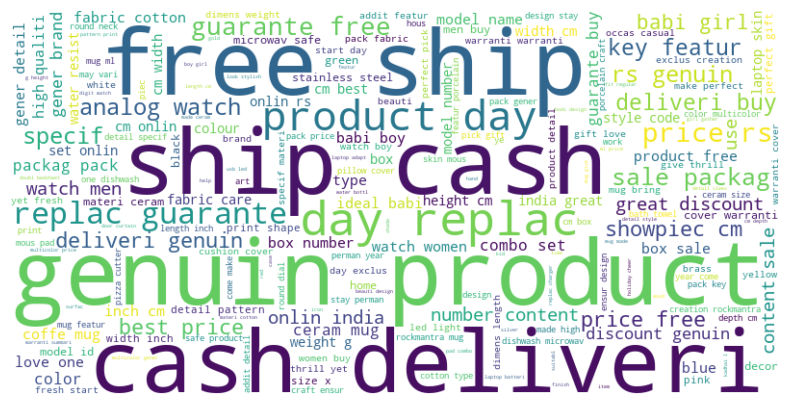

In [29]:
generate_wordcloud(preprocessed_corpus)

## Bag-of-Words (Comptage Simple de Mots et TF-IDF) :
TF = Term Frequency
IDF = Inverse Document Frequency
Poids = Fréquence du terme x indicateur de similarité

BoW consiste à représenter chaque document sous forme d'un vecteur où chaque élément représente la fréquence d'un mot dans le document.

In [30]:
# Créer un dictionnaire de mots uniques avec des indices uniques
word_to_index = {word: idx for idx, word in enumerate(unique_word_counts)}

# Initialiser une liste pour stocker les vecteurs BoW de chaque document
bow_vectors = []

# Parcourir chaque document dans le corpus
for document in corpus:
    # Compter les occurrences de chaque mot dans le document
    word_counts = Counter(document)
    
    # Créer un vecteur BoW pour le document en utilisant le dictionnaire de mots uniques
    bow_vector = [word_counts.get(word, 0) for word in unique_word_counts]
    
    # Ajouter le vecteur BoW à la liste des vecteurs
    bow_vectors.append(bow_vector)


TF-IDF (Term Frequency-Inverse Document Frequency) est similaire à BoW, mais il pondère les fréquences des mots en fonction de leur importance dans l'ensemble du corpus.

In [31]:
# Créer un objet TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Adapter et transformer les données textuelles pour obtenir la représentation TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_corpus)

# tfidf_matrix contient la représentation TF-IDF données textuelles

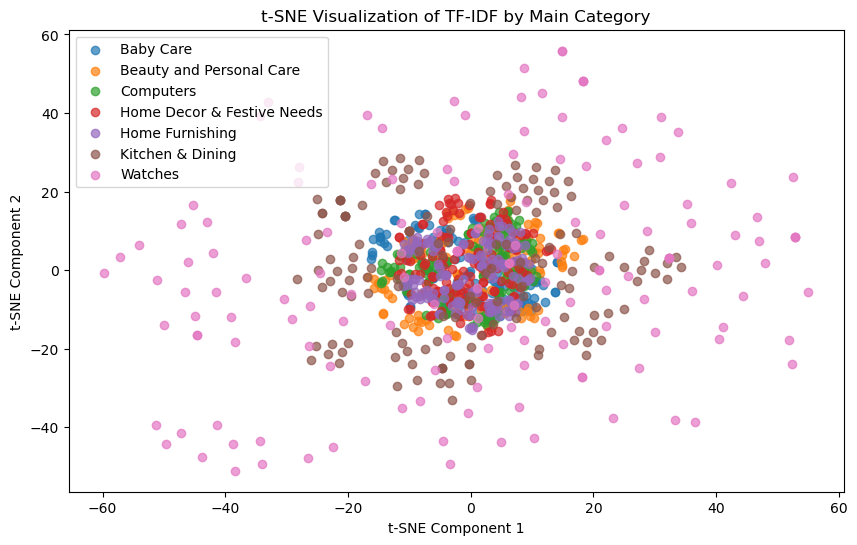

In [32]:
# Calculer les vecteurs TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_corpus)

# Créer un DataFrame pour stocker les vecteurs TF-IDF et les catégories principales correspondantes
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['main_category'] = data['main_category']

# Initialiser t-SNE
tsne = TSNE(n_components=2, random_state=42)

# Grouper les vecteurs TF-IDF par main_category et appliquer t-SNE
tsne_results = {}
for main_category, group in tfidf_df.groupby('main_category'):
    tsne_results[main_category] = tsne.fit_transform(group.drop(columns=['main_category']))

# Afficher les résultats avec des couleurs différentes pour chaque main_category
plt.figure(figsize=(10, 6))
for main_category, tsne_result in tsne_results.items():
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], label=main_category, alpha=0.7)
plt.legend()
plt.title('t-SNE Visualization of TF-IDF by Main Category')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

## Word/Sentence Embedding avec Word2Vec (ou GloVe ou FastText)

In [42]:
# Entraînement du modèle Word2Vec sur l'ensemble du corpus
word2vec_model = Word2Vec(preprocessed_corpus, min_count=1)

# Initialisation d'une liste pour stocker les embeddings de chaque document
embeddings = []

# Parcours de chaque document dans le corpus
for document in preprocessed_corpus:
    # Initialisation d'un vecteur pour stocker la somme des vecteurs de mots
    document_vector = np.zeros(word2vec_model.vector_size)
    # Compteur pour le nombre de mots dans le document
    word_count = 0
    # Calcul de la somme des vecteurs de mots pour chaque mot dans le document
    for word in document:
        if word in word2vec_model.wv:
            document_vector += word2vec_model.wv[word]
            word_count += 1
    # Calcul de la moyenne des vecteurs de mots pour obtenir l'embedding du document
    if word_count != 0:
        document_vector /= word_count
    # Ajout de l'embedding à la liste
    embeddings.append(document_vector)

# Convertir la liste en un tableau numpy
embeddings = np.array(embeddings)


# Images 

Prétraiter des données non structurées de type image en veillant au respect du droit à l’image et réaliser un feature engineering adapté aux modèles d'apprentissage afin d’obtenir un jeu de données exploitables.
* CE1 Le candidat a utilisé des librairies spécialisées pour un premier traitement du contraste (ex. : openCV). 
* CE2 Le candidat a présenté des opérations de retraitement d'images (par exemple passage en gris, filtrage du bruit, égalisation, floutage) sur un ou plusieurs exemples. 
* CE3 Le candidat a élaboré une fonction permettant d'extraire des features ("feature engineering") de type "bag-of-images" via la génération de descripteurs (algorithmes ORB, ou SIFT, ou SURF). 
* CE4 Le candidat a élaboré et exécuté une fonction permettant d'extraire des features ("feature engineering") via un algorithme de Transfer Learning basé sur des réseaux de neurones, comme par exemple CNN. 
* CE5 Le candidat s’assure que les images utilisées ne relèvent pas d’une propriété intellectuelle.

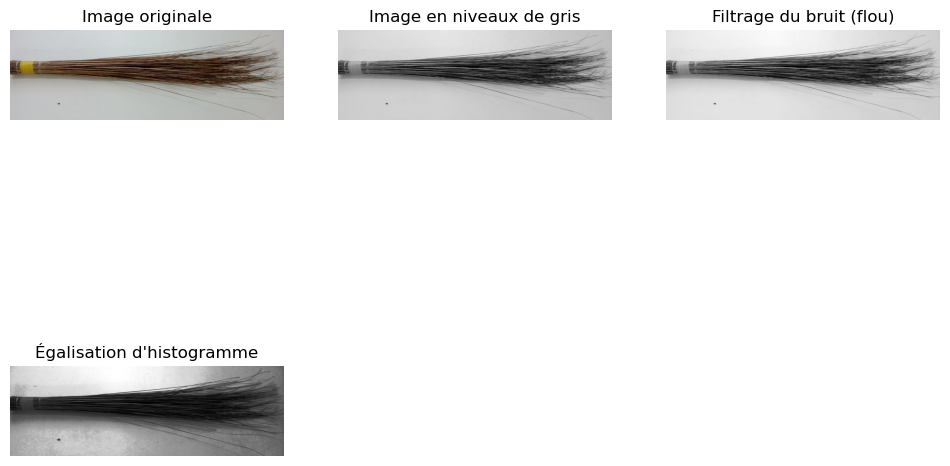

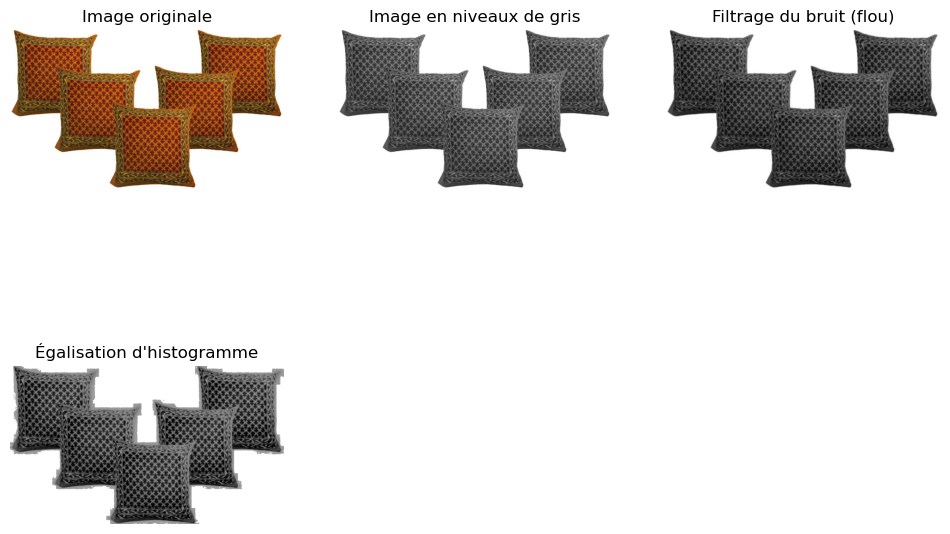

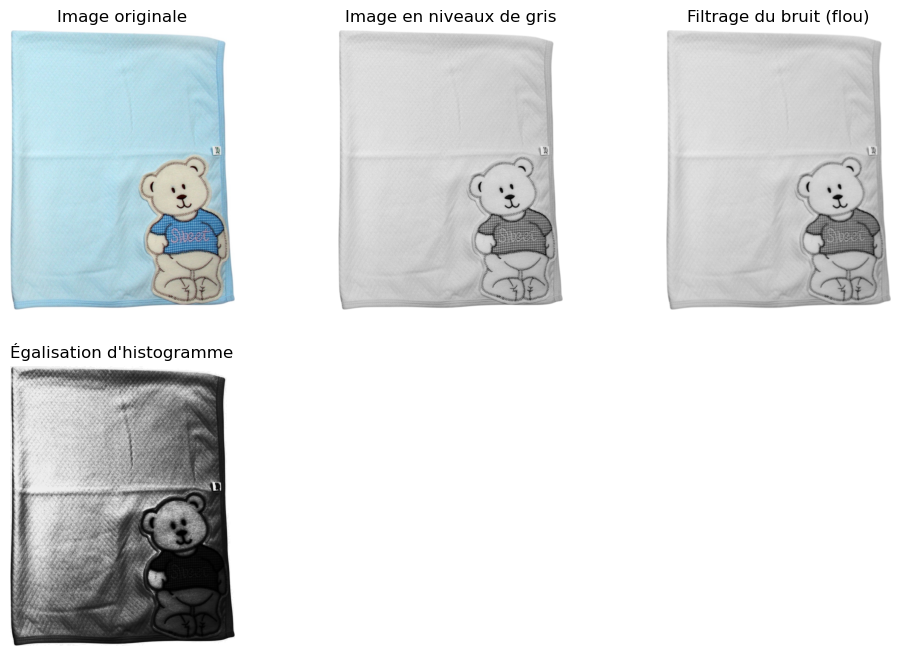

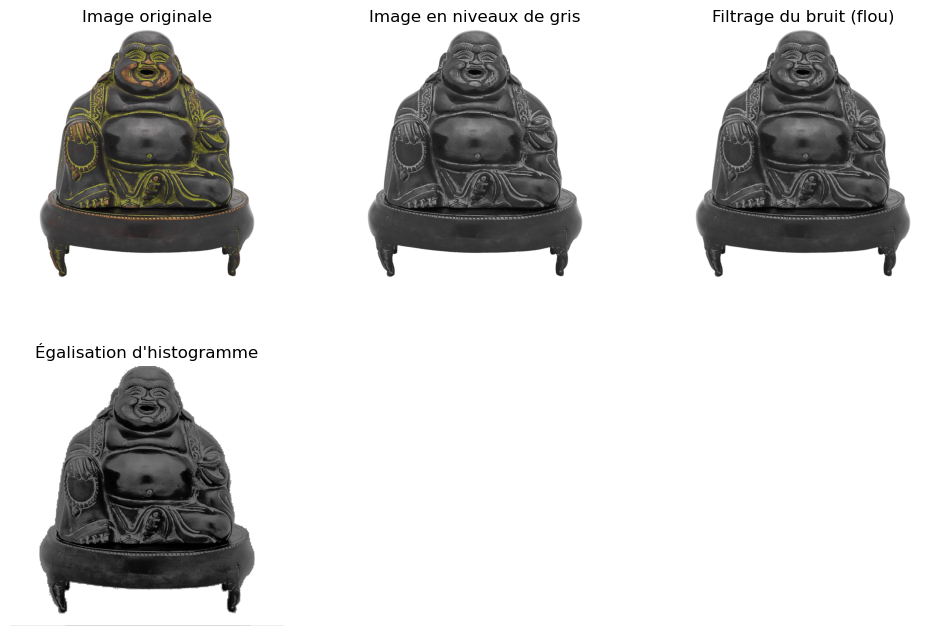

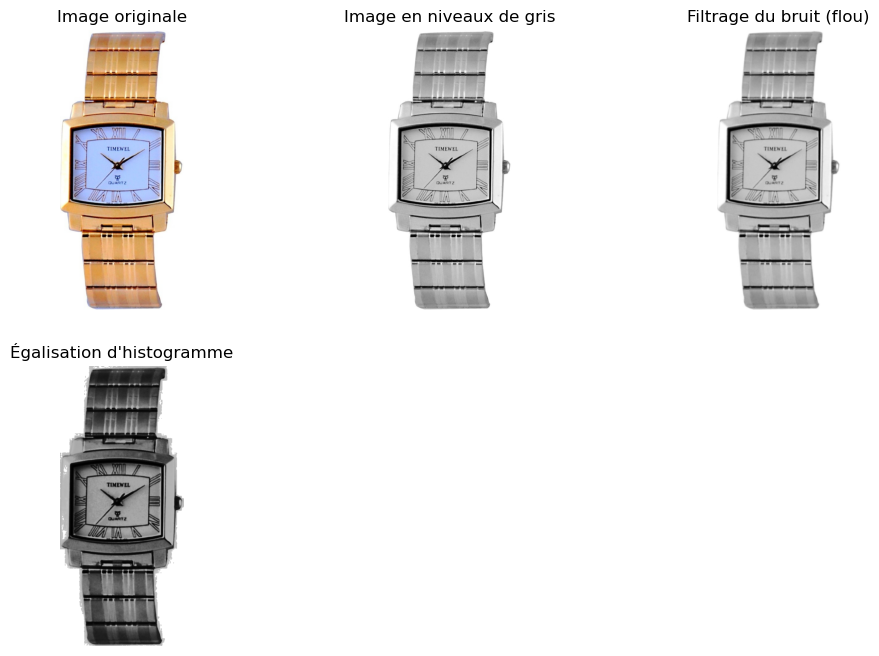

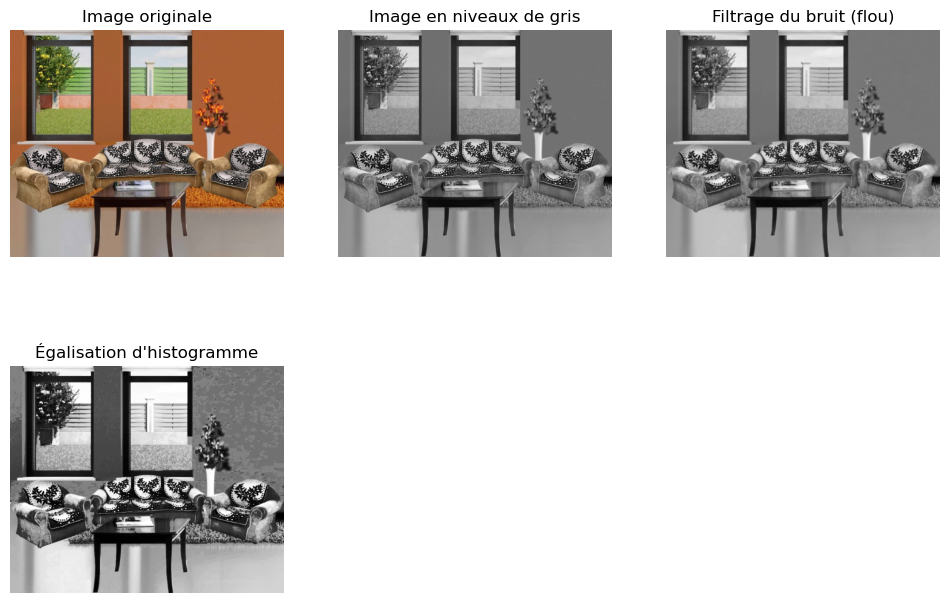

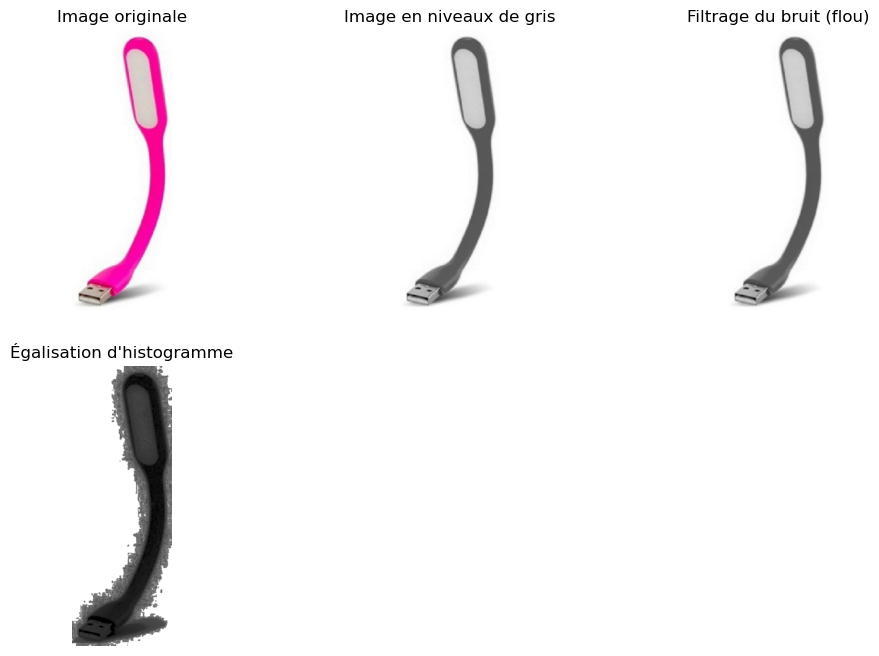

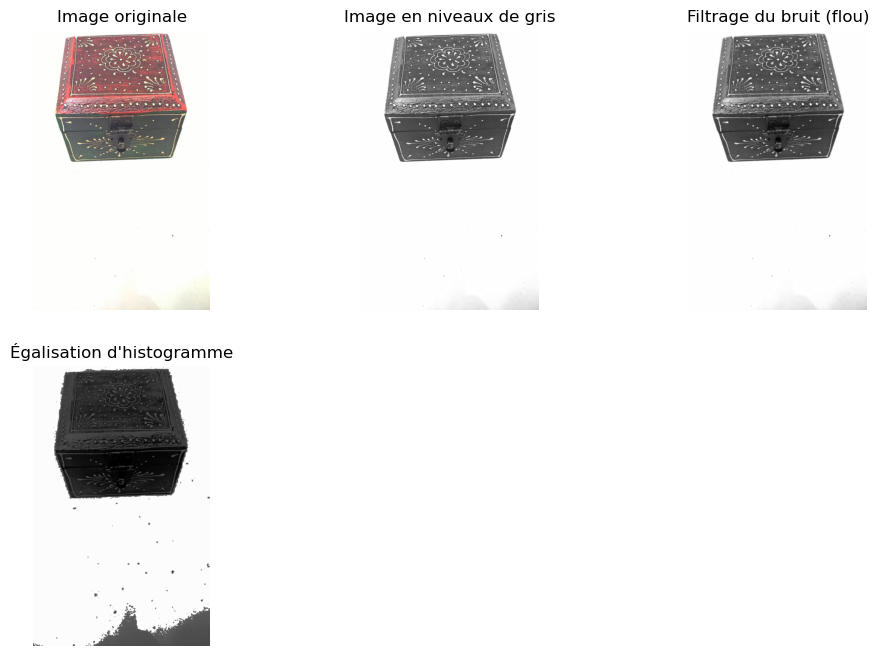

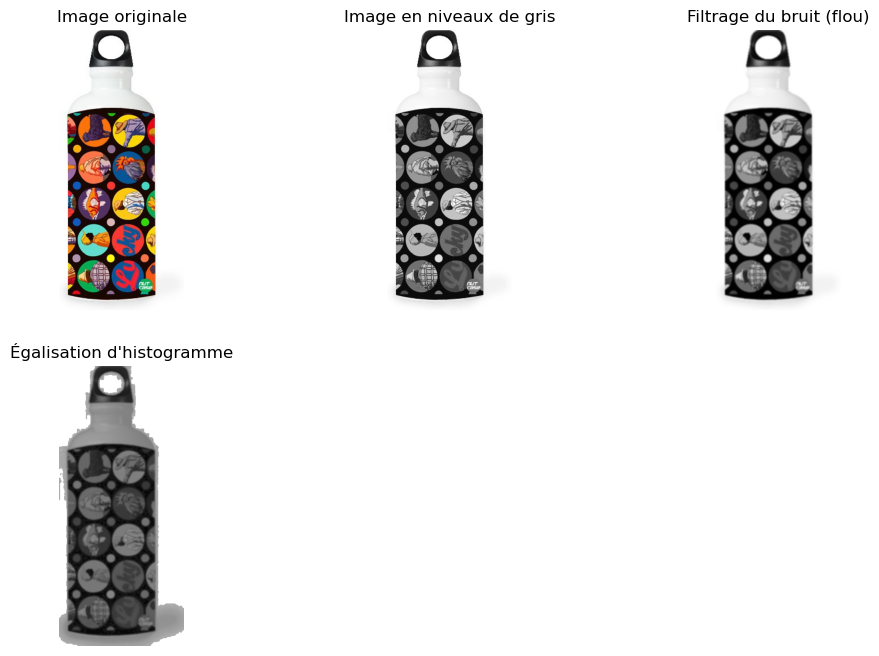

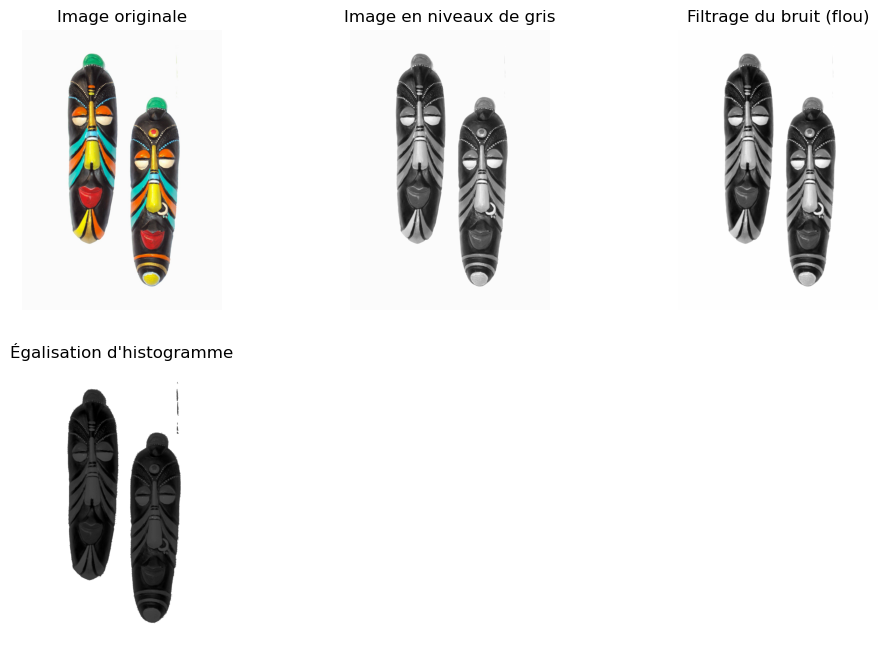

In [33]:
# Chemin vers le dossier contenant les images
dossier_images = "../Source/Images/"

# Liste des fichiers dans le dossier
fichiers_images = os.listdir(dossier_images)

# Définir une liste d'opérations de retraitement
operations_retraitement = [
    ("Image en niveaux de gris", cv2.cvtColor, cv2.COLOR_BGR2GRAY),
    ("Filtrage du bruit (flou)", cv2.GaussianBlur, (5, 5), 0),
    ("Égalisation d'histogramme", cv2.equalizeHist),
]

# Traiter chaque image avec les opérations spécifiées
for fichier_image in fichiers_images[:10]:  # Traitement sur les 10 premières images pour l'exemple
    # Construire le chemin complet de l'image
    chemin_image = os.path.join(dossier_images, fichier_image)

    # Charger l'image depuis le fichier
    image = cv2.imread(chemin_image)

    # Créer une grille pour afficher les résultats
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Image originale")
    plt.axis('off')

    # Appliquer chaque opération et afficher le résultat
    for i, (titre, operation, *args) in enumerate(operations_retraitement, start=2):
        if args:
            image = operation(image, *args)
        else:
            image = operation(image)

        plt.subplot(2, 3, i)
        plt.imshow(image, cmap='gray')
        plt.title(titre)
        plt.axis('off')

    # Afficher la grille d'images
    plt.show()

## Pré-traitement

## Prioprioté intellectuelle

Mail de Linda : 

" PS : J’ai bien vérifié qu’il n’y avait aucune contrainte de propriété intellectuelle sur les données et les images."
